In [1]:
import numpy as np
from pydrake.all import StartMeshcat, RotationMatrix, RigidTransform
# from mobile_base_ik import solve_ik, set_position
from mobile_iiwa import set_position
from IPython.display import display, Image, SVG
import pydot
from matplotlib import pyplot as plt

[(1, 4), (1, 5), (2, 2), (2, 3), (4, 1), (4, 2), (4, 4), (5, 1), (5, 2)]

- add_model:
    name: mountain1
    file: file:///workspaces/6.4210_project/objects/mountain_OBJ.sdf
- add_weld:
    parent: world
    child: mountain1::mountain_OBJ
    X_PC:
        translation: [-4.5, 2.25, 0]       
        
- add_model:
    name: mountain2
    file: file:///workspaces/6.4210_project/objects/mountain_OBJ.sdf
- add_weld:
    parent: world
    child: mountain2::mountain_OBJ
    X_PC:
        translation: [-4.5, 4.5, 0]       
        
- add_model:
    name: mountain3
    file: file:///workspaces/6.4210_project/objects/mountain_OBJ.sdf
- add_weld:
    parent: world
    child: mountain3::mountain_OBJ
    X_PC:
        translation: [-2.25, -2.25, 0]       
        
- add_model:
    name: mountain4
    file: file:///workspaces/6.4210_project/objects/mountain_OBJ.sdf
- add_weld:
    parent: world
    child: mountain4::mountain_OBJ
    X_PC:
        translation: [-2.25, 0.0, 0]       
        
- add

In [2]:
# Start the visualizer.
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7000


## Problem Description
We will solve inverse kinematics for one arm on a PR2 robot. This robot model has been modified to have convex collision geometries, and to simplify this problem, we have welded (fixed) several joints that are irrelavent to the kinematics of the arms.

In [3]:
goal_rotation = RotationMatrix(
    [
        [1, 0, 0],
        [0, -1, 0],
        [0, 0, -1],
    ]
)
goal_position = np.array([-1, -1, 1])
goal_pose = RigidTransform(goal_rotation, goal_position)

### IK for a Mobile Manipulator

Given a RigidTransform X_WG, compute a robot configuration placing the left gripper at that pose. We use optimization to solve the IK problem, and we repeatedly solve the program with random initializations until it succeeds. We have implemented a skeleton of the necessary code in the following function, but you must complete several pieces:

- Add position and orientation constraints to the gripper frame. The end effector should match the desired pose to within 1mm translation along each axis, and the rotation should be off by no more than 1 degree.
- If `fix_base` is True, constrain the base pose $(x,y,\theta)$ to be equal to `base_pose`.
- Add a collision free constraint with [AddMinimumDistanceLowerBoundConstraint](https://drake.mit.edu/doxygen_cxx/classdrake_1_1multibody_1_1_inverse_kinematics.html#a2ecd71efd675a7e1a4293adb05c9b9df). The minimum distance between any pair of collision geometries should be at least 1cm.
- Compute a random initial guess for the joint angles within the robot's joint limits. You can access the joint limits from the multibody plant, but some of the joints are angle-valued and don't have limits. For these joints, use the range $[-\pi,\pi]$.

First, we show an example where we have fixed the base. It may take many tries for it to solve, or not solve at all! At each iteration, we visualize where the optimizer stopped, so you can see what the failures look like.

When we allow the base to move freely, the inverse kinematics can be solved much more easily!

In [4]:
from mobile_iiwa import set_position

In [5]:
# from mobile_base_ik import solve_ik, set_position
from mobile_iiwa import set_position
from IPython.display import display, Image, SVG
import pydot
from matplotlib import pyplot as plt

/workspaces/6.4210_project
['iiwa_iiwa_base_x_x', 'iiwa_iiwa_base_y_x', 'iiwa_iiwa_base_z_x', 'iiwa_iiwa_joint_1_q', 'iiwa_iiwa_joint_2_q', 'iiwa_iiwa_joint_3_q', 'iiwa_iiwa_joint_4_q', 'iiwa_iiwa_joint_5_q', 'iiwa_iiwa_joint_6_q', 'iiwa_iiwa_joint_7_q', 'wsg_left_finger_sliding_joint_x', 'wsg_right_finger_sliding_joint_x', 'object1_obstacles_qw', 'object1_obstacles_qx', 'object1_obstacles_qy', 'object1_obstacles_qz', 'object1_obstacles_x', 'object1_obstacles_y', 'object1_obstacles_z', 'object2_obstacles_qw', 'object2_obstacles_qx', 'object2_obstacles_qy', 'object2_obstacles_qz', 'object2_obstacles_x', 'object2_obstacles_y', 'object2_obstacles_z', 'iiwa_iiwa_base_x_v', 'iiwa_iiwa_base_y_v', 'iiwa_iiwa_base_z_v', 'iiwa_iiwa_joint_1_w', 'iiwa_iiwa_joint_2_w', 'iiwa_iiwa_joint_3_w', 'iiwa_iiwa_joint_4_w', 'iiwa_iiwa_joint_5_w', 'iiwa_iiwa_joint_6_w', 'iiwa_iiwa_joint_7_w', 'wsg_left_finger_sliding_joint_v', 'wsg_right_finger_sliding_joint_v', 'object1_obstacles_wx', 'object1_obstacles_wy'

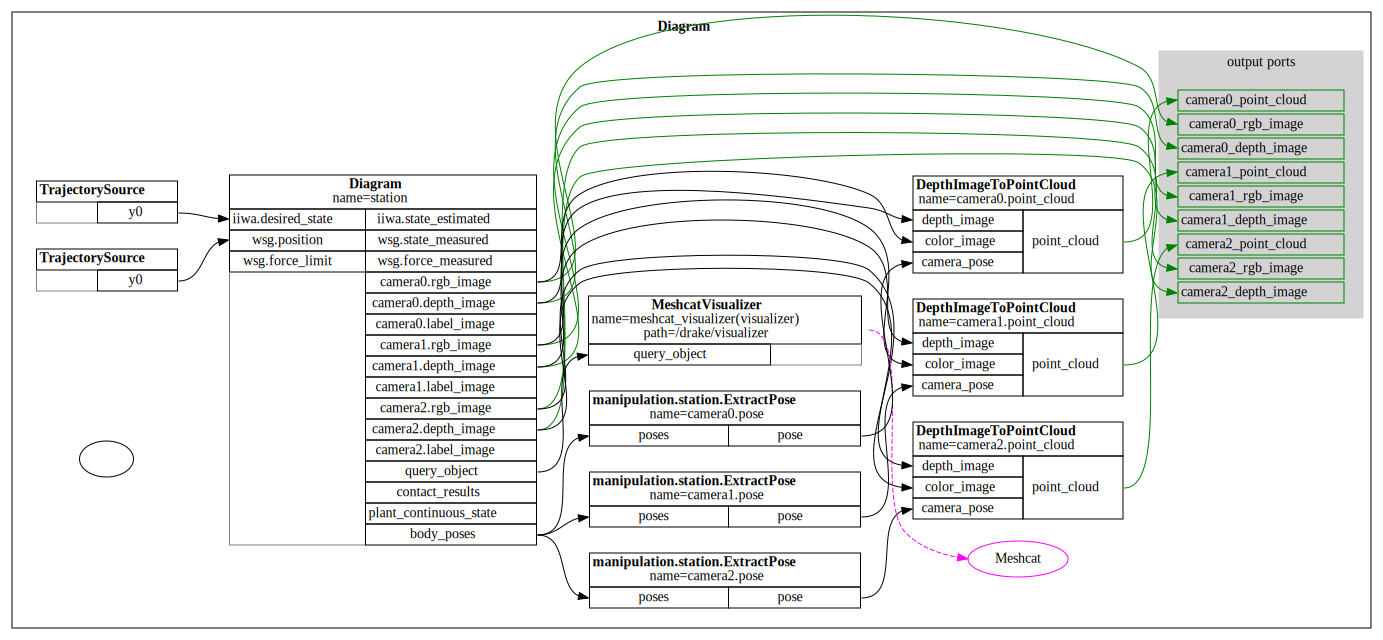

In [11]:
gripper_poses = [RigidTransform([0.5, 0, 0.5]), RigidTransform([0.5, 0, 0]), RigidTransform([0.5, 0, 0]), RigidTransform([0.5, 0, 0]), RigidTransform([0.5, 0, 0.5]), RigidTransform([0, -0.3, 0.5]), RigidTransform([-0.5, -0.3, 0.5]), RigidTransform([-.5, 0, 0.5]), RigidTransform([-.5, 0, 0.5])] 
x, y = (1, 1)
goal = (-0.545 + x, -0.07 + y)
diagram, station = set_position(meshcat, goal_pose, gripper_poses=gripper_poses, goal=goal)
SVG(
    pydot.graph_from_dot_data(diagram.GetGraphvizString(max_depth=1))[
        0
    ].create_svg())

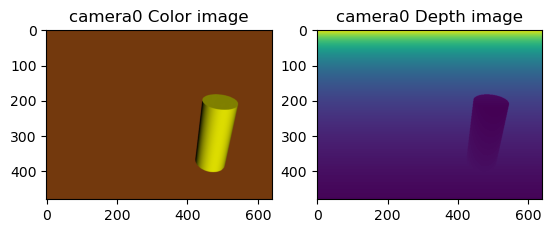

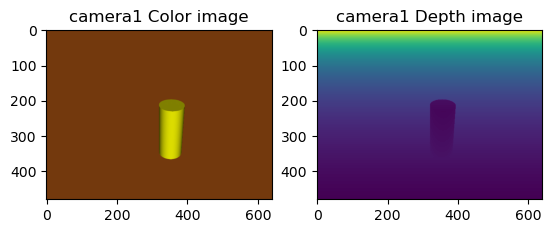

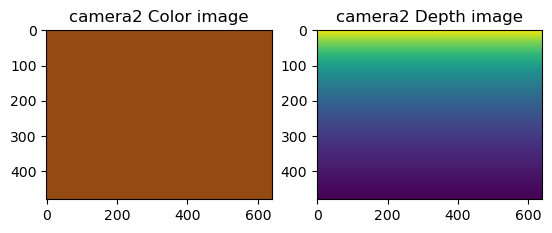

In [13]:
system = diagram
context = system.CreateDefaultContext()
system.ForcedPublish(context)
for i in range(3):
    color_image = system.GetOutputPort(f"camera{i}_rgb_image").Eval(context)
    depth_image = system.GetOutputPort(f"camera{i}_depth_image").Eval(context)

    # Plot the two images.
    plt.subplot(121)
    plt.imshow(color_image.data)
    plt.title(f"camera{i} Color image")
    plt.subplot(122)
    plt.imshow(np.squeeze(depth_image.data))
    plt.title(f"camera{i} Depth image")
    # mpld3.display()
    plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=99019c02-9e81-448d-8532-b07e66cf3903' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>